# Neural Network Design and Aanalysis

---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 0. Data preparation & defining functions 




In [ ]:
def display_num_param(net):
	nb_param = 0
	for param in net.parameters():
	    nb_param += param.numel()
	print('There are {} ({:.2f} million) parameters in this neural network'.format(
		nb_param, nb_param/1e6)
	     )

In [ ]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs 

In [ ]:
def show(X):
    if X.dim() == 3 and X.size(0) == 3:
        plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')

In [ ]:
def show_prob_mnist(p):

    p=p.data.squeeze().numpy()

    ft=15
    label = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight','nine')
    #p=p.data.squeeze().numpy()
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9
    col= 'blue'
    #col='darkgreen'

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])
    #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()  
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])
    #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)


    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax.transData, color= col,fontsize=ft)

    plt.show()
    #fig.savefig('pic/prob', dpi=96, bbox_inches="tight")

In [ ]:
import scipy.io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mat = scipy.io.loadmat('/content/drive/My Drive/CZ3005_Lab2/OQC.mat')

In [ ]:
data=mat['data']
data

array([[0.39052473, 0.14779758, 0.1563981 , ..., 0.07962529, 0.92246927,
        2.        ],
       [0.39052473, 0.14779758, 0.1563981 , ..., 0.05367681, 0.92148159,
        2.        ],
       [0.5084938 , 0.14779758, 0.1563981 , ..., 0.05611241, 0.9204939 ,
        2.        ],
       ...,
       [0.54001505, 0.00982888, 0.77251185, ..., 0.05611241, 0.93135813,
        0.        ],
       [0.60664394, 0.00982888, 0.77251185, ..., 0.05658079, 0.93086416,
        0.        ],
       [0.7189506 , 0.00982888, 0.77251185, ..., 0.05658079, 0.93086416,
        0.        ]])

In [ ]:
# split train and test 
import pandas as pd
import numpy as np
#use this package just to split train and test dataset only
from sklearn.model_selection import train_test_split 
data_df = pd.DataFrame(data)

train_data, test_data, train_label, test_label = train_test_split(data_df.iloc[:,0:48], data_df.iloc[:,-1], test_size=0.3, random_state=42)

train_data = train_data.to_numpy()
train_label=train_label.to_numpy()
test_data=test_data.to_numpy()
test_label=test_label.to_numpy()

train_data = torch.Tensor(train_data)
train_label=torch.LongTensor(train_label)
test_data=torch.Tensor(test_data)
test_label=torch.LongTensor(test_label)

# check train and test size 
print(train_data.size())
print(train_label.size())
print(test_data.size())
print(test_label.size())


torch.Size([2066, 48])
torch.Size([2066])
torch.Size([886, 48])
torch.Size([886])


In [ ]:

test_data

tensor([[0.0880, 0.1048, 0.5972,  ..., 0.1887, 0.1887, 0.9817],
        [1.0000, 0.0724, 0.4123,  ..., 0.0259, 0.0259, 0.9136],
        [1.0000, 0.0750, 0.5403,  ..., 0.0266, 0.0266, 0.9170],
        ...,
        [1.0000, 0.1110, 0.2986,  ..., 0.0238, 0.0238, 0.9096],
        [1.0000, 0.0131, 0.6209,  ..., 0.0259, 0.0259, 0.9304],
        [1.0000, 0.0739, 0.3981,  ..., 0.0257, 0.0257, 0.9131]])

## 1. Model Design and Implementation


##### Defining model, training, and testing functions:**


In [ ]:
# Define the 3-layer NN model 

class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(three_layer_net , self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size1  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2  , bias=False  )
        self.layer3 = nn.Linear(  hidden_size2 , output_size   , bias=False  )
        
    def forward(self, x):
        
        y = self.layer1(x)
        y_hat = F.relu(y)
        z = self.layer2(y_hat)
        z_hat = F.relu(z)
        scores = self.layer3(z_hat)
        
        return scores

In [ ]:
# Define NN testing function

def testing_nn(bs, net):
  running_error=0
  num_batches=0

  for i in range(0,int(len(test_data))-1,bs):

      # extract the minibatch
      minibatch_data =  test_data[i:i+bs]
      minibatch_label= test_label[i:i+bs]

      # reshape the minibatch
      # inputs = minibatch_data.view(bs,48)
      inputs = minibatch_data

      # feed it to the network
      scores=net( inputs )
      
      # compute the error made on this batch
      error = get_error( scores , minibatch_label)
      
      # add it to the running error
      running_error += error.item()

      num_batches+=1
      
  # compute error rate on the full test set
  total_error = running_error/num_batches

  print( 'error rate on test set =', total_error*100 ,'percent')

  return total_error


In [ ]:
# Define NN Training function 

def training_nn(no_of_epochs, bs, lr,net):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer=torch.optim.SGD(net.parameters() , lr=lr )
  
    start = time.time()

    for epoch in range(no_of_epochs):
    
        running_loss=0
        running_error=0
        num_batches=0

        shuffled_indices=torch.randperm(len(train_data))

        for count in range(1, int(len(train_data))-1, bs):
 
            # Set dL/dU, dL/dV, dL/dW to be filled with zeros
            optimizer.zero_grad()

            # create a minibatch
            indices=shuffled_indices[count:count+bs]
            minibatch_data =  train_data[indices]
            minibatch_label= train_label[indices]

            #reshape the minibatch
            ##inputs = minibatch_data.view(bs,48)
            inputs = minibatch_data

            # tell Pytorch to start tracking all operations that will be done on "inputs"
            inputs.requires_grad_()

            # forward the minibatch through the net  
            scores=net( inputs ) 

            # Compute the average of the losses of the data points in the minibatch
            loss = criterion(scores , minibatch_label) 

            # backward pass to compute dL/dU, dL/dV and dL/dW    
            loss.backward()

            # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
            optimizer.step()

            # compute and accumulate stats
            running_loss += loss.detach().item()
            error = get_error( scores.detach() , minibatch_label)
            running_error += error.item()
            
            ###print(error.item())
            ###print("running error",running_error)
            num_batches+=1

        # End of inner for-loop 

        # compute stats for the full training set
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        elapsed = time.time()-start

        ##print('epoch=',epoch, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        if epoch%10 == 0:
            print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
           # testing_nn(bs, net) 
            print(' ')

    #End of outer for-loop
    return total_loss, total_error, time.time()


##### **Find the optimal sets of hyper parameters**

In [ ]:
# Run the model to find the optimal hyperparameters 

# Create a dataframe to store the results 
import pandas as pd
results_q1 = pd.DataFrame(columns = ["lr","nodes_hidden_1", "nodes_hidden_2", "no_of_epochs","bs","train_loss", "train_error", "train_time", "test_error"])

# hyperparameters inputs to be looped through 
learning_rates = [0.01,0.05,0.1] # commonly-used learning rates 
nodes_hidden_1_loop = [5,25,45]
nodes_hidden_2_loop = [5,25,45]
minibatch_sizes = [10,20,200,500]
epochs = [10,20,50,100]

# loop through all possible combinations of the hyperparameters 
for lr in learning_rates:
  for nodes_hidden_1 in nodes_hidden_1_loop:
    for nodes_hidden_2 in nodes_hidden_2_loop:
      if nodes_hidden_2 <= nodes_hidden_1:
        for no_of_epochs in epochs:
          for  bs in minibatch_sizes:
            net = three_layer_net(48, nodes_hidden_1, nodes_hidden_2, 3)
            train_loss, train_error, train_time = training_nn(no_of_epochs, bs, lr,net)
            test_error = testing_nn(bs, net)

            result = [lr,nodes_hidden_1,nodes_hidden_2,no_of_epochs,bs,train_loss,train_error,train_time,test_error]
            print(result)

            result = pd.Series(result, index = results_q1.columns)
            results_q1 = results_q1.append(result, ignore_index=True)


In [ ]:
# view results dataframe 
results_q1

,lr,nodes_hidden_1,nodes_hidden_2,no_of_epochs,bs,train_loss,train_error,train_time,test_error
0,0.01,5.0,5.0,10.0,10.0,0.933388,0.671498,1.635172e+09,0.619850
1,0.01,5.0,5.0,10.0,20.0,1.087997,0.564423,1.635172e+09,0.572222
2,0.01,5.0,5.0,10.0,200.0,1.098078,0.606329,1.635172e+09,0.590581
3,0.01,5.0,5.0,10.0,500.0,1.098588,0.691631,1.635172e+09,0.679674
4,0.01,5.0,5.0,20.0,10.0,0.831674,0.362319,1.635172e+09,0.373408
...,...,...,...,...,...,...,...,...,...
283,0.10,45.0,45.0,50.0,500.0,0.351454,0.129692,1.635172e+09,0.220580
284,0.10,45.0,45.0,100.0,10.0,0.000095,0.000000,1.635172e+09,0.000000
285,0.10,45.0,45.0,100.0,20.0,0.000224,0.000000,1.635172e+09,0.000000
286,0.10,45.0,45.0,100.0,200.0,0.021470,0.000455,1.635172e+09,0.007000


In [ ]:
# Locate the optimal combinations of hyperparameters 
min_test_error = results_q1["test_error"].min()
optimal_hyperparameters = results_q1[results_q1["test_error"]==min_test_error]
pd.set_option("display.max_rows",100)
optimal_hyperparameters 

,lr,nodes_hidden_1,nodes_hidden_2,no_of_epochs,bs,train_loss,train_error,train_time,test_error
12,0.01,5.0,5.0,100.0,10.0,0.005603,0.000000,1.635172e+09,0.0
28,0.01,25.0,5.0,100.0,10.0,0.005088,0.000000,1.635172e+09,0.0
44,0.01,25.0,25.0,100.0,10.0,0.004757,0.000000,1.635172e+09,0.0
60,0.01,45.0,5.0,100.0,10.0,0.006872,0.000000,1.635172e+09,0.0
72,0.01,45.0,25.0,50.0,10.0,0.025286,0.001449,1.635172e+09,0.0
76,0.01,45.0,25.0,100.0,10.0,0.004988,0.000000,1.635172e+09,0.0
77,0.01,45.0,25.0,100.0,20.0,0.021194,0.000000,1.635172e+09,0.0
92,0.01,45.0,45.0,100.0,10.0,0.005240,0.000000,1.635172e+09,0.0
93,0.01,45.0,45.0,100.0,20.0,0.019040,0.000000,1.635172e+09,0.0
100,0.05,5.0,5.0,20.0,10.0,0.009194,0.000483,1.635172e+09,0.0


##### **Final Solution**

From the above, we can observe that there are multiple sets of hyperparameters that can achive the minimal test errors. Hence, to solve questions 1, we could use any one sets of hyperparameters from the above "optimal_hyperparameters" dataframe. 
<br>
However, as we know that:<br>
1. Model accuracy increases when learning rate decreases 
2. Model accuracy increases as the number of hidden nodes increases 
3. Model accuracy increases as the number of epochs increases 
4. Model accuracy increases as the number of batch size decreases 
<br><br>
We can then pick the set of hyperparameters from the "optimal_hyperparameters" dataframe that has: lowest learning rate, lowest batch size, highest number of hidden nodes, and highest number of epochs. 
<br>
With that, the optimal hyperparameter used for the model will be on index 92. where:

- learning rate: 0.01 
- no. of hidden nodes on layer 1: 45
- no. of hidden nodes on layer 2: 45
- no. of epochs: 100
- batch size: 10


## 2. Effects of Hidden layers & Hidden nodes

### 2.1 Effects of hidden layers

In [ ]:
# hyperparameters that are not evaluated in this questions are kept constant 
no_of_epochs = 20
lr = 0.08
bs = 20

##### **Defining models**

In [ ]:
# Define a shallow network with 2 layers 

class shallow_net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(shallow_net, self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size , hidden_size  , bias=False  )

        
    def forward(self, x):
        
        y = self.layer1(x)
        y_hat = F.relu(y)

        scores = self.layer2(y_hat)
        return scores

In [ ]:
# Define a deep network with 4 layers 
class deep_net(nn.Module):

    def __init__(self, input_size, hidden_size,  output_size):
        super(deep_net, self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size , hidden_size  , bias=False  )
        self.layer3 = nn.Linear(  hidden_size , hidden_size   , bias=False  )
        self.layer4 = nn.Linear(  hidden_size , output_size   , bias=False  )

        
    def forward(self, x):
        
        y = self.layer1(x)
        y_hat = F.relu(y)

        z = self.layer2(y_hat)
        z_hat = F.relu(z)

        j = self.layer3(z_hat)
        j_hat=F.relu(j)

        scores = self.layer4(j_hat)
        
        return scores

##### **Implementing the models with different number of layers**

In [ ]:
# Run the model on shallow net 
shallow = shallow_net(48, 5, 3)

train_loss, train_error, train_time = training_nn(no_of_epochs, bs, lr,shallow )
test_error = testing_nn(bs, shallow)

print("shallow_net model performance: \n")

print("learning rate: ", lr)
print("number of epochs:", no_of_epochs)
print("training loss: ", train_loss)
print("training error: ", train_error)
print("training time: ", train_time)
print("\ntesting error: ", test_error)

epoch= 0 	 time= 0.05571603775024414 	 loss= 1.2700049854241884 	 error= 64.03846150407423 percent
 
epoch= 10 	 time= 0.561607837677002 	 loss= 1.0524956526664586 	 error= 64.80769222745528 percent
 
error rate on test set = 65.81481470002069 percent
shallow_net model performance: 

learning rate:  0.08
number of epochs: 20
training loss:  0.9689667534369689
training error:  0.6495192291644903
training time:  1635165220.7560189

testing error:  0.6581481470002069


In [ ]:
# Run the model on 3-layer model
net = three_layer_net(48, 5,5, 3)

train_loss, train_error, train_time = training_nn(no_of_epochs, bs, lr, net)
test_error = testing_nn(bs, net)

print("3-layer model performance: \n")

print("learning rate: ", lr)
print("number of epochs:", no_of_epochs)
print("training loss: ", train_loss)
print("training error: ", train_error)
print("training time: ", train_time)

print("\ntesting error: ", test_error)

epoch= 0 	 time= 0.06526470184326172 	 loss= 1.0832952100497026 	 error= 58.31730738282204 percent
 
epoch= 10 	 time= 0.6820058822631836 	 loss= 0.14603871261127865 	 error= 4.182692961050914 percent
 
error rate on test set = 3.7777784135606556 percent
3-layer model performance: 

learning rate:  0.08
number of epochs: 20
training loss:  0.13102685953848636
training error:  0.041346160838237174
training time:  1635164049.377642

testing error:  0.037777784135606556


In [ ]:
# Run the model on deep net (4 layers)
deep = deep_net(48, 5, 3)

train_loss, train_error, train_time = training_nn(no_of_epochs, bs, lr, deep)
test_error = testing_nn(bs, deep)

print("4-layer model performance: \n")

print("learning rate: ", lr)
print("number of epochs:", no_of_epochs)
print("training loss: ", train_loss)
print("training error: ", train_error)
print("training time: ", train_time)

print("\ntesting error: ", test_error)

epoch= 0 	 time= 0.06553149223327637 	 loss= 1.0977511933216682 	 error= 58.509615350228096 percent
 
epoch= 10 	 time= 0.6953864097595215 	 loss= 0.07986447911333436 	 error= 2.836539023197614 percent
 
error rate on test set = 0.22222227520412868 percent
deep_net model performance: 

learning rate:  0.08
number of epochs: 20
training loss:  0.007677724603966523
training error:  0.00048076934539354767
training time:  1635163989.7208872

testing error:  0.0022222227520412867


### 2.2 Effects of hidden nodes

##### **Implementing a mode lwith different number of hidden nodes**

In [ ]:
# Run a model with different nuber of hidden nodes
results_q2 = pd.DataFrame(columns = ["lr","no of hidden nodes", "no_of_epochs","bs","train_loss", "train_error", "train_time", "test_error"])

hidden_nodes_loop = [5,10, 20, 30,40, 45 ]

for hidden_nodes in hidden_nodes_loop:
  shallow = shallow_net(48, hidden_nodes, 3)

  train_loss, train_error, train_time = training_nn(no_of_epochs, bs, lr,shallow )
  test_error = testing_nn(bs, shallow)  

  result = [lr,hidden_nodes,no_of_epochs,bs,train_loss,train_error,train_time,test_error]
  print(result)

  result = pd.Series(result, index = results_q2.columns)
  results_q2 = results_q2.append(result, ignore_index=True)


##### **Visualize the model performance/results**

In [ ]:
results_q2

,lr,no of hidden nodes,no_of_epochs,bs,train_loss,train_error,train_time,test_error
0,0.08,5.0,20.0,20.0,0.065127,0.017308,1.635167e+09,0.078889
1,0.08,10.0,20.0,20.0,0.047278,0.005769,1.635167e+09,0.006667
2,0.08,20.0,20.0,20.0,0.046698,0.006731,1.635167e+09,0.001111
3,0.08,30.0,20.0,20.0,0.041909,0.004327,1.635167e+09,0.003333
4,0.08,40.0,20.0,20.0,0.052978,0.008654,1.635167e+09,0.002222
5,0.08,45.0,20.0,20.0,0.055441,0.011538,1.635167e+09,0.005556


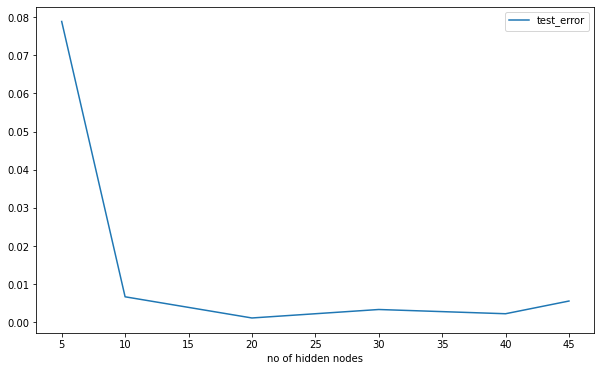

In [ ]:
results_q2.plot(x="no of hidden nodes",y="test_error", figsize = (10,6))

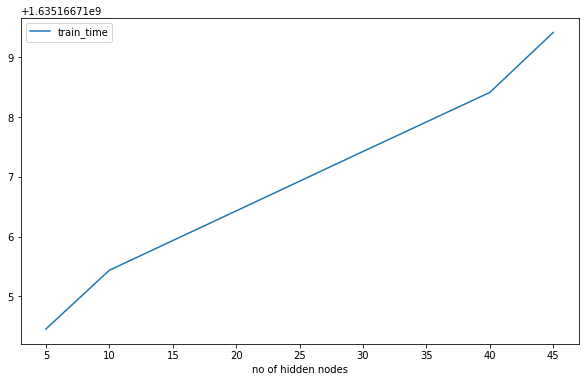

In [ ]:
results_q2.plot(x="no of hidden nodes",y="train_time", figsize = (10,6))

## 3. Effects of Learning Rate 

In [ ]:
# Hyperparameters that are not evaluated in this question are kept constant 
bs = 20
no_of_epochs = 20
nodes_hidden_1 = 5
nodes_hidden_2 = 5

# A range of learnign rates to explore 
learning_rates_q3 = [0.01,0.02,0.05,0.07,0.1,0.12,0.15]

### 3.1 Non-adaptive Model

##### **Implementing the model using different learning rates**

In [ ]:
results_q3_1 = pd.DataFrame(columns = ["lr","nodes_hidden_1", "nodes_hidden_2", "no_of_epochs","bs","train_loss", "train_error", "train_time", "test_error"])

# Run the model to find the optimal hyperparameters 

for lr in learning_rates_q3:
    net = three_layer_net(48, nodes_hidden_1, nodes_hidden_2, 3)

    train_loss, train_error, train_time = training_nn(no_of_epochs, bs, lr,net)
    test_error = testing_nn(bs, net)

    result = [lr,nodes_hidden_1,nodes_hidden_2,no_of_epochs,bs,train_loss,train_error,train_time,test_error]
    print(result)

    result = pd.Series(result, index = results_q3_1.columns)
    results_q3_1 = results_q3_1.append(result, ignore_index=True)

##### **View and visualize the model performance/results**

In [ ]:
results_q3_1

,lr,nodes_hidden_1,nodes_hidden_2,no_of_epochs,bs,train_loss,train_error,train_time,test_error
0,0.01,5.0,5.0,20.0,20.0,1.055869,0.650962,1.635171e+09,0.679259
1,0.02,5.0,5.0,20.0,20.0,0.239366,0.088942,1.635171e+09,0.112593
2,0.05,5.0,5.0,20.0,20.0,0.447954,0.328365,1.635171e+09,0.329630
3,0.07,5.0,5.0,20.0,20.0,0.067044,0.025000,1.635171e+09,0.024444
4,0.10,5.0,5.0,20.0,20.0,0.383881,0.311538,1.635171e+09,0.315185
5,0.12,5.0,5.0,20.0,20.0,0.006429,0.000000,1.635171e+09,0.000000
6,0.15,5.0,5.0,20.0,20.0,0.121276,0.038942,1.635171e+09,0.036667


In [ ]:
results_q3_1.plot(x="lr",y="test_error", figsize = (10,6))

In [ ]:
results_q3_1.plot(x="lr",y="train_time", figsize = (10,6))

### 3.2 Adaptive Model

##### **Defining a NN cyclical training function**

In [ ]:
# Define NN cyclical Training function 

def training_nn_cyclicLR(no_of_epochs, bs, lr,net):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer=torch.optim.SGD(net.parameters() , lr=lr )
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr, max_lr=0.15)
  
    start = time.time()

    for epoch in range(no_of_epochs):
    
        running_loss=0
        running_error=0
        num_batches=0

        shuffled_indices=torch.randperm(len(train_data))

        for count in range(1, int(len(train_data))-1, bs):
 
            # Set dL/dU, dL/dV, dL/dW to be filled with zeros
            optimizer.zero_grad()

            # create a minibatch
            indices=shuffled_indices[count:count+bs]
            minibatch_data =  train_data[indices]
            minibatch_label= train_label[indices]

            #reshape the minibatch
            ##inputs = minibatch_data.view(bs,48)
            inputs = minibatch_data

            # tell Pytorch to start tracking all operations that will be done on "inputs"
            inputs.requires_grad_()

            # forward the minibatch through the net  
            scores=net( inputs ) 

            # Compute the average of the losses of the data points in the minibatch
            loss = criterion(scores , minibatch_label) 

            # backward pass to compute dL/dU, dL/dV and dL/dW    
            loss.backward()

            # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
            optimizer.step()
            scheduler.step()

            # compute and accumulate stats
            running_loss += loss.detach().item()
            error = get_error( scores.detach() , minibatch_label)
            running_error += error.item()
            
            ###print(error.item())
            ###print("running error",running_error)
            num_batches+=1

        # End of inner for-loop 

        # compute stats for the full training set
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        elapsed = time.time()-start

        ##print('epoch=',epoch, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        if epoch%10 == 0:
            print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
           # testing_nn(bs, net) 
            print(' ')

    #End of outer for-loop
    return total_loss, total_error, time.time()


##### **Implementing the cyclical model using different learning rates**

In [ ]:
results_q3_2 = pd.DataFrame(columns = ["lr","nodes_hidden_1", "nodes_hidden_2", "no_of_epochs","bs","train_loss", "train_error", "train_time", "test_error"])

# Run the model to find the optimal hyperparameters 

for lr in learning_rates_q3:
    net = three_layer_net(48, nodes_hidden_1, nodes_hidden_2, 3)

    train_loss, train_error, train_time = training_nn_cyclicLR(no_of_epochs, bs, lr,net)
    test_error = testing_nn(bs, net)

    result = [lr,nodes_hidden_1,nodes_hidden_2,no_of_epochs,bs,train_loss,train_error,train_time,test_error]
    print(result)

    result = pd.Series(result, index = results_q3_2.columns)
    results_q3_2 = results_q3_2.append(result, ignore_index=True)

#### **View and visualize the model performance/results**

In [ ]:
results_q3_2

,lr,nodes_hidden_1,nodes_hidden_2,no_of_epochs,bs,train_loss,train_error,train_time,test_error
0,0.01,5.0,5.0,20.0,20.0,0.797797,0.647596,1.635172e+09,0.679259
1,0.02,5.0,5.0,20.0,20.0,1.098612,0.649038,1.635172e+09,0.679259
2,0.05,5.0,5.0,20.0,20.0,0.759772,0.647596,1.635172e+09,0.679259
3,0.07,5.0,5.0,20.0,20.0,1.098612,0.647596,1.635172e+09,0.679259
4,0.10,5.0,5.0,20.0,20.0,0.742588,0.647596,1.635172e+09,0.679259
5,0.12,5.0,5.0,20.0,20.0,1.098612,0.652404,1.635172e+09,0.679259
6,0.15,5.0,5.0,20.0,20.0,0.715681,0.647596,1.635172e+09,0.679259


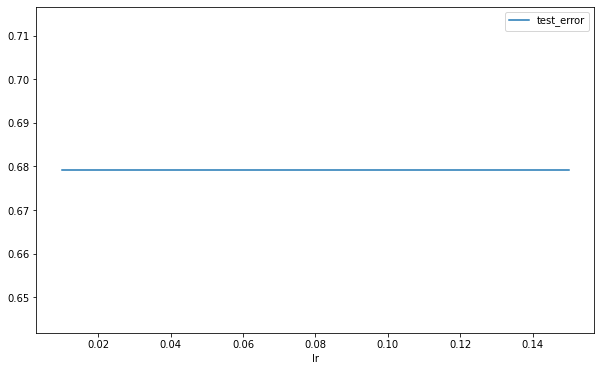

In [ ]:
results_q3_2.plot(x="lr",y="test_error", figsize = (10,6))

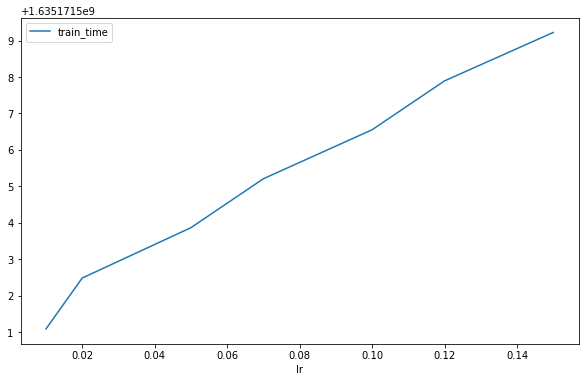

In [ ]:
results_q3_2.plot(x="lr",y="train_time", figsize = (10,6))

## 4. Effects of batch size 

In [ ]:
# define the set of different minibatch size to loop through 
batch_sizes = [1, 2, 5, 10, 25, 50, 100, 300, 500, 1000, 1500, len(train_data)] 

In [ ]:
# Hyperparameters that are note evaluated in this question are kept constant 
nodes_hidden_1 = 5
nodes_hidden_2 = 5
no_of_epochs = 20
lr = 0.01

##### **Implementing the model using different batch size**

In [ ]:
results_q4 = pd.DataFrame(columns = ["lr","nodes_hidden_1", "nodes_hidden_2", "no_of_epochs","bs","train_loss", "train_error", "train_time", "test_error"])

# Run the model to find the optimal hyperparameters 

for bs in batch_sizes:
    net = three_layer_net(48, nodes_hidden_1, nodes_hidden_2, 3)

    train_loss, train_error, train_time = training_nn(no_of_epochs, bs, lr,net)
    test_error = testing_nn(bs, net)

    result = [lr,nodes_hidden_1,nodes_hidden_2,no_of_epochs,bs,train_loss,train_error,train_time,test_error]
    print(result)

    result = pd.Series(result, index = results_q4.columns)
    results_q4 = results_q4.append(result, ignore_index=True)



##### **View and visualize the model performance/results**

In [ ]:
results_q4

,lr,nodes_hidden_1,nodes_hidden_2,no_of_epochs,bs,train_loss,train_error,train_time,test_error
0,0.01,5.0,5.0,20.0,1.0,0.009807,0.002907,1.635169e+09,0.003390
1,0.01,5.0,5.0,20.0,2.0,0.025388,0.007752,1.635169e+09,0.000000
2,0.01,5.0,5.0,20.0,5.0,0.084488,0.025182,1.635169e+09,0.014689
3,0.01,5.0,5.0,20.0,10.0,0.788072,0.649275,1.635169e+09,0.679401
4,0.01,5.0,5.0,20.0,25.0,1.093958,0.630201,1.635169e+09,0.612626
5,0.01,5.0,5.0,20.0,50.0,1.039591,0.578413,1.635169e+09,0.560679
6,0.01,5.0,5.0,20.0,100.0,1.091910,0.602344,1.635169e+09,0.592351
7,0.01,5.0,5.0,20.0,300.0,1.092535,0.649137,1.635169e+09,0.679386
8,0.01,5.0,5.0,20.0,500.0,1.099619,0.672031,1.635169e+09,0.685674
9,0.01,5.0,5.0,20.0,1000.0,1.097514,0.682846,1.635169e+09,0.669300


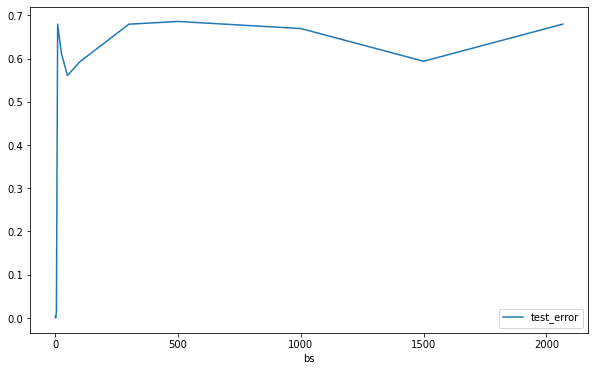

In [ ]:
results_q4.plot(x="bs",y="test_error", figsize = (10,6))

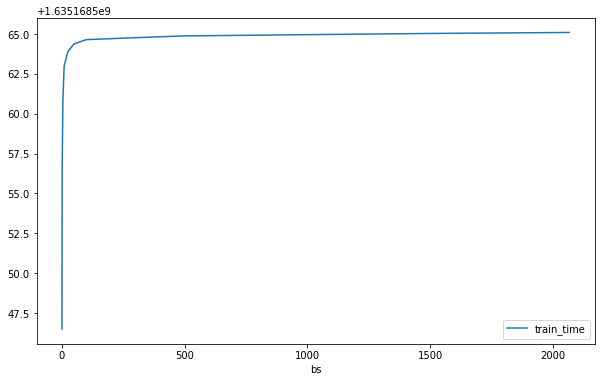

In [ ]:
results_q4.plot(x="bs",y="train_time", figsize = (10,6))